<a href="https://colab.research.google.com/github/mdkamrulhasan/gvsu_machine_learning/blob/main/notebooks/mountain_car_Reinforcement_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Adapting from:

*   https://medium.com/@MachineLearningYearning/, and
*   https://gist.github.com/GiovanniGatti/933c61340bfbc361f3effd0c25d1cf1d



# Mountain Car Problem

Let's implement our first reinforcement learning algorithm to address the Mountain Car task.

The Mountain Car task is a hard one.  The agent must pilot an underpowered car up a steep mountain road. The diculty is that gravity is stronger than the car's engine, and even at full throttle the car cannot accelerate up the steep slope. The only solution is to first move away from the goal and up the opposite slope on the left. Then, by applying full throttle the car can build p enough inertia to carry it up the steep slope even though it is slowing down the whole way. This is a simple example of a continuous control task where things must get worse in a sense (farther from the goal) before they can get better. Many control methodologies have great diculties with tasks of this kind unless explicitly aided by a human designer.

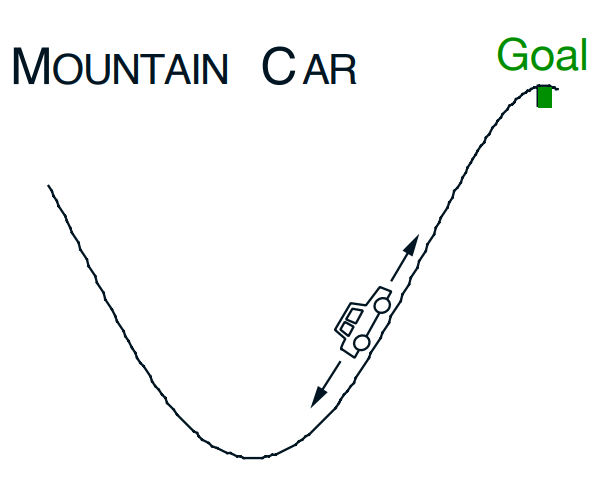

To get started, let's first install and import dependencies.

In [ ]:
#!sudo apt-get install python3.7 > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install -y xvfb > /dev/null 2>&1
!apt-get install -y python-opengl ffmpeg > /dev/null 2>&1
!pip install gym==0.22.0 pyvirtualdisplay > /dev/null 2>&1

In [ ]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only

import math
import random
import numpy as np

from typing import Tuple, List, Optional

import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

Below we have two helper functions that enable Google Colab display videos from our agent's interaction with its environment.

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

# Getting Familiar with the Environment

As we've seen in last workshop, [Gym](https://gym.openai.com/) is a opensource plataform that provides various reinforcement learning environments. Today, we write our algorithm and test it in the environment 'MountainCar-v0'.

First, let's get familiar with our environment.

In [ ]:
env = wrap_env(gym.make('MountainCar-v0'))
env.seed(0)

[0]

Let's first take a look in our state space.

In [ ]:
env.observation_space

Box([-1.2  -0.07], [0.6  0.07], (2,), float32)

From Gym documentation, the 'Box' space represents an n-dimensional box, so valid observations will be an array of 2 real numbers. Typically,

where the first index represents the x-position of the car and the second represents car velocity.

Now let's take a look at the action space.

In [ ]:
env.action_space

Discrete(3)

Again, following Gym's documentation, the Discrete space allows a fixed range of non-negative numbers, so in this case valid actions are either 0 or 1 or 2.
Use the cell below to figure out what each one corresponds.

**Exercise:** Modify the action to be taken by the agent (0, 1, 2) and then watch agents’ behavior. The goal is to figure out what each one corresponds to.

In [ ]:
env.reset()
obs, reward, done, info = env.step(2)
obs, reward

(array([-0.47198862,  0.00061906], dtype=float32), -1.0)

### Testing an example action, move right (2)

In [ ]:
ACTION = 2
for i in range(200):
  obs, reward, done, info = env.step(ACTION)
  env.render()

  if done:
    break

env.close()
show_video()

# Applying a simple strategy



*   Go Back and Forth to accelerate speed




In [ ]:
env = wrap_env(gym.make('MountainCar-v0'))
env.seed(0)
obs = env.reset()
env.render()
print(obs[1])

0.0


In [ ]:
for i in range(200):

  # decide what our next action should be,
  # based on our current observation of the environment
  if obs[1] > 0:
        action = 2
  else:
        action = 0

  obs, reward, done, info = env.step(action)
  env.render()

  if done:
    break

env.close()
show_video()

# RL Begins Here ..

# Split Observation Space into Discreate Bins

### Split Observation Space into Discreate Bins

In [ ]:
# choose number of gridpoints to use
n_grid = 10
# calculate grids to discretize observations
gridspace = {}
for ii, s in enumerate(zip(env.observation_space.low, env.observation_space.high)):
    gridspace[ii] = np.linspace(s[0], s[1], n_grid)
gridspace[0].shape, gridspace[1].shape

((10,), (10,))

# Utility Functions

### Discritization of the search space

In [ ]:
# define a function that makes it easy to get our discretized indices from an obervation
def get_discretized_observation(observation):
    index = np.array([np.argmin(np.abs(grid-observation[ii]))
                          for (ii, grid) in gridspace.items()])
    return index

get_discretized_observation([-1.3, 0.01])

array([0, 5])

In [ ]:
def run_episode():
    ''' Collect data from a single episode. '''
    data = {}
    next_obs = env.reset()
    for t in range(1000):
        if next_obs[1] > 0: # if velocity is positive
            # go right
            action = 2
        else:
            # go left
            action = 0
        # The response of the environment in return to the action
        next_obs, reward, done, info = env.step(action)
        # store action-response instance
        data[t] = {'observation': next_obs, 'reward': reward,
                   'done': done, 'info': info, 'action': action}
        if done:
            break
    return data

# Value function

Value function

In [ ]:
# prepare our value function, intializing each state to be infinitely unrewarding
value_function = -np.infty*np.ones([n_grid]*2)
# let's keep a counter of each time we saw a given (discretized) observation
state_counts = np.zeros([n_grid]*2) ## kh - how many times the agent ata a particular state is??

In [ ]:
value_function.shape, state_counts.shape

((10, 10), (10, 10))

# Running Episodes

### Mainly for Exploration

In [ ]:
n_episodes = 1000
for ep in range(n_episodes):
    data = run_episode()

    times = np.array([t for t in data.keys()])

    total_episode_reward = 0

    # loop backward in time, since the
    # value of each state is its *future* reward

    # kh - Backtract to evaluate your initial (state) selection ??
    for t in range(times[-1], -1, -1):
        total_episode_reward += data[t]['reward']
        ii = get_discretized_observation(data[t]['observation'])

        if value_function[ii[0], ii[1]] == -np.infty: # initialization
            value_function[ii[0], ii[1]] = 0.0

        # kh : how many times did the agent visitied this state?
        state_counts[ii[0], ii[1]] += 1
        # kh - what is the corresponding total reward (from current episode)
        value_function[ii[0], ii[1]] += total_episode_reward

### Normalize values

In [ ]:
# Now, we just compute the averages for our value function
# Average reward per state (if an agent visits a statue mukitple times)
value_function[state_counts>0] = value_function[state_counts>0] / state_counts[state_counts>0]

# Action-Value Function
- The value function we obtained in the previous section only considers state.
- In contrast, an action-value function takes actions into account. In other words, the action-value function measures the average expected future reward for a given state and value pair.

We need to add more dimension to store the action

In [ ]:
# prepare our value function, intializing each state to be infinitely unrewarding
action_value_function = -np.infty*np.ones([n_grid]*2 + [3])
# let's keep a counter of each time we saw a given (discretized) observation
state_action_counts = np.zeros([n_grid]*2 + [3])

updating the 3D matrix as the value function before

In [ ]:
n_episodes = 1000 #00
for ep in range(n_episodes):
    data = run_episode()

    times = np.array([t for t in data.keys()])

    total_episode_reward = 0

    # loop backward in time, since the value
    # of each state is its *future* value


    # kh - Backtract to evaluate your initial (state, action) selection ??
    for t in range(times[-1], -1, -1):
        total_episode_reward += data[t]['reward']
        ii = get_discretized_observation(data[t]['observation'])

        if action_value_function[ii[0], ii[1], data[t]['action']] == -np.infty:
            action_value_function[ii[0], ii[1], data[t]['action']] = 0.0

        state_action_counts[ii[0], ii[1], data[t]['action']] += 1 # state counter
        action_value_function[ii[0], ii[1], data[t]['action']] += total_episode_reward

### Normalization (Averaging)

In [ ]:
# Now, we just compute the averages for our value function
action_value_function[state_action_counts>0] = action_value_function[state_action_counts>0] / state_action_counts[state_action_counts>0]

It may seem that we’ve just accomplished exactly the same thing. However, since the action-value function tells us how good each action is, we can use it to choose the best action at each state. Let’s try it.

### Take action based on what we have learned before (and stored in our value function)

In [ ]:
env = wrap_env(gym.make('MountainCar-v0'))
env.seed(0)

[0]

In [ ]:
obs = env.reset()
for _ in range(1000):

    # decide what our action will be given this observation
    ii = get_discretized_observation(obs)

    # TAKE THE BEST ACTION as per the value function
    action = np.argmax(action_value_function[ii[0], ii[1]])

    obs, reward, done, info = env.step(action)
    env.render()
    if done:
        break

env.close()
show_video()

The solution above is as good as our static hard-coded strategy as we in the beginning!

So the agent is learning from the environment -- the heart of RL

# Q-Learning

- An optimized action-value function
- ML

In [ ]:
alpha = .15
# our action-value function. we call it Q now, just to follow convention
Q = np.zeros([n_grid]*2 + [3])
n_episodes = 2000
for ep in range(n_episodes):
    obs = env.reset()

    # kh - start at a random state (place, velocity) ??
    ii = get_discretized_observation(obs)
    # kh - take a random action
    action = np.random.choice([0,1,2])

    # kh - start with a random choice
    # then optimize based on sucdessive decisions and corresponding rewards
    # the dynamics is stored in the Q-Table
    for t in range(1000):
        next_obs, reward, done, info = env.step(action)
        # kh - next observation index
        next_ii = get_discretized_observation(next_obs)
        # kh - best next action as per the current Q-table
        next_action = np.argmax(Q[next_ii[0], next_ii[1]])

        if done:
            # kh - FOUND A SOLUTION
            if np.mod(ep, 100) == 0:
                print('Episode ended after %d steps' % t)
            if t < 199:
                # we'll help along learning
                # by adding an extra reward when the agent succeeds
                Q[ii[0], ii[1], action] += alpha * (1 - Q[ii[0], ii[1], action])
            break
        # kh - NO SOLUTION FOUND YET
        else:
            # updating previous (state, action) index
            # result will be UPDATED CURRENT INDEX (after the statement is executed)
            Q[ii[0], ii[1], action] += alpha * (
                # reward due to current action (+ve)
                reward +
                # max of next index (x vs velocity) ?? (+ve)
                np.max(Q[next_ii[0], next_ii[1]]) -
                # previous index (x, velocity) (-ve)
                Q[ii[0], ii[1],
                  action])
        action = next_action
        obs = next_obs
        ii = next_ii

Episode ended after 199 steps
Episode ended after 199 steps
Episode ended after 199 steps
Episode ended after 199 steps
Episode ended after 174 steps
Episode ended after 199 steps
Episode ended after 199 steps
Episode ended after 187 steps
Episode ended after 199 steps
Episode ended after 199 steps
Episode ended after 149 steps
Episode ended after 199 steps
Episode ended after 199 steps
Episode ended after 181 steps
Episode ended after 199 steps
Episode ended after 199 steps
Episode ended after 199 steps
Episode ended after 199 steps
Episode ended after 199 steps
Episode ended after 107 steps


- The biggest difference between this code and our earlier code is that there are only two loops: we learn the action-value function as we play the game, rather than running an entire episode with a fixed action-value function.
- Most of the work is done on a single line: Q[ii[0], ii[1], action] += alpha * (reward + np.max(Q[next_ii[0], next_ii[1]]) - Q[ii[0], ii[1], action]).
- This line updates the **previous state's action-value** with the reward and the next-state's action value. Over time, this update will converge to an optimal **action-value function**. Remember, the action-value function is just a measure of how good (rewarding) each pair of state and action really is.

Let’s check that this action-value function has actually learned to solve the problem. We can use it just as we did before with our previous action-value function.

In [ ]:
env = wrap_env(gym.make('MountainCar-v0'))
env.seed(0)

[0]

In [ ]:
obs = env.reset()
for _ in range(1000):

    # decide what our action will be given this observation
    ii = get_discretized_observation(obs)

    action = np.argmax( Q[ii[0], ii[1]])

    obs, reward, done, info = env.step(action)
    env.render()
    if done:
        break

env.close()
show_video()

You should see that your learned Q can solve the MountainCar problem quickly. If not, try re-running, or increasing the number of episodes (n_episodes) used for training.

How does this learned Q differ from the action-value function we learned earlier? Does it execute a different policy?

At this point, you probably have already figured out that actions 0, 1 and 2 corresponds respectively to full throttle reverse, zero throttle and full throttle forward.